--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BRUSSELS ---
--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---


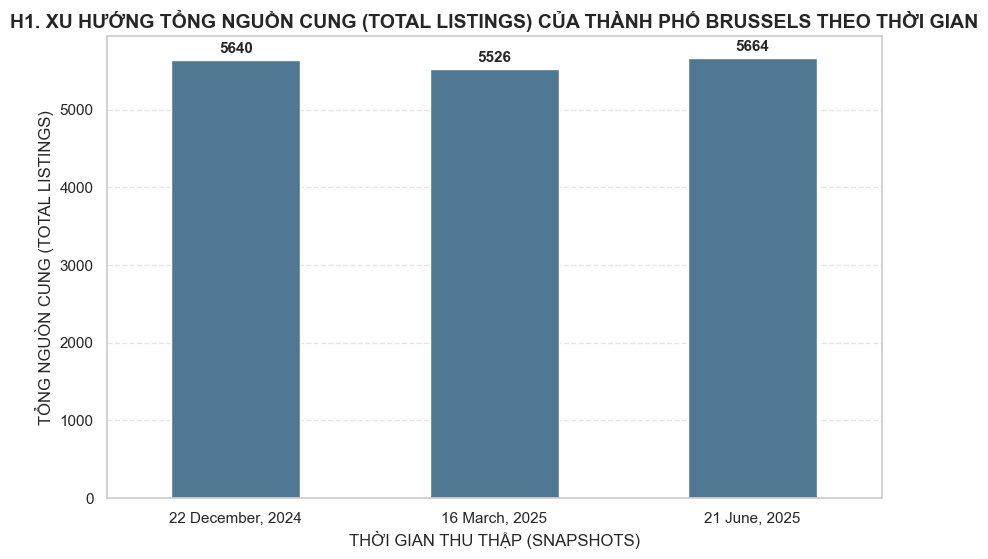

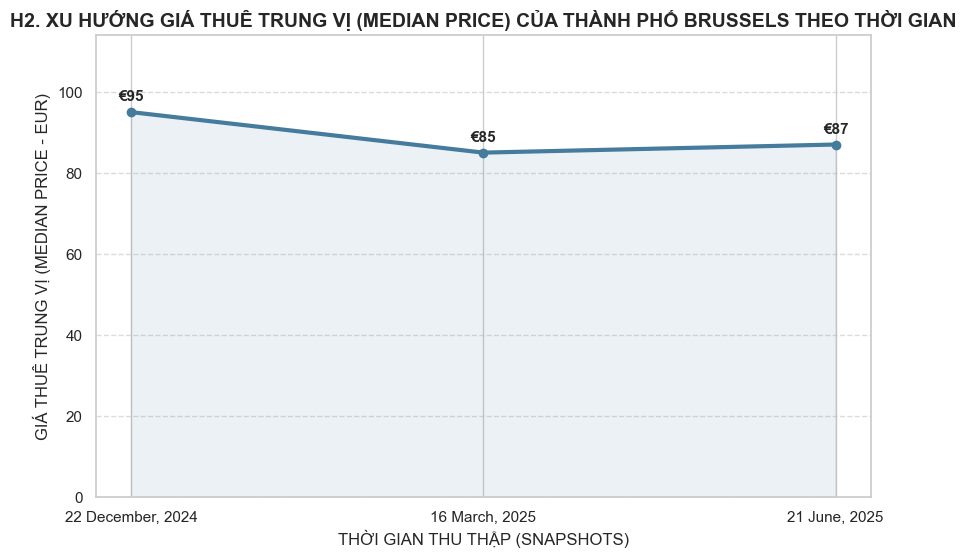

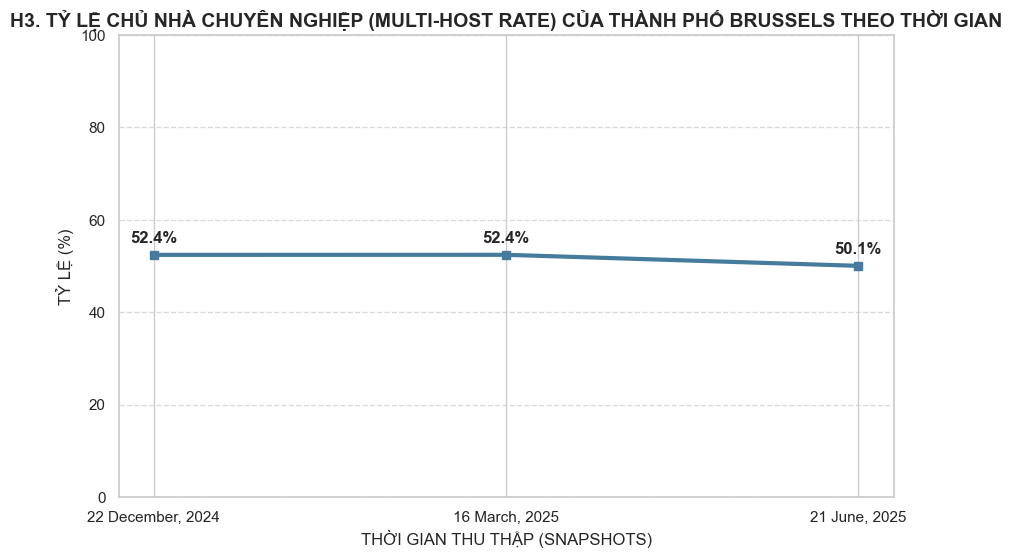

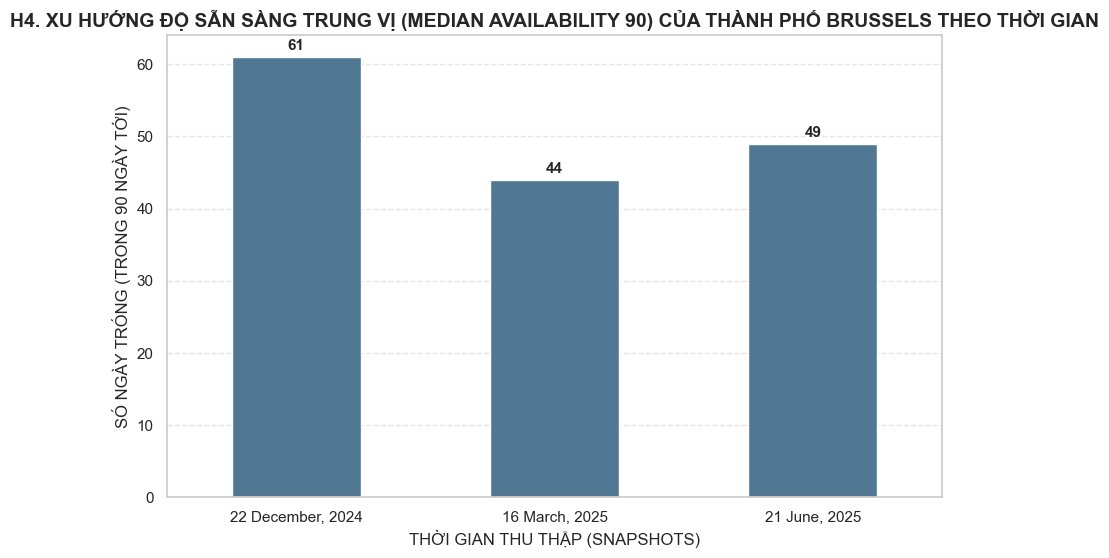

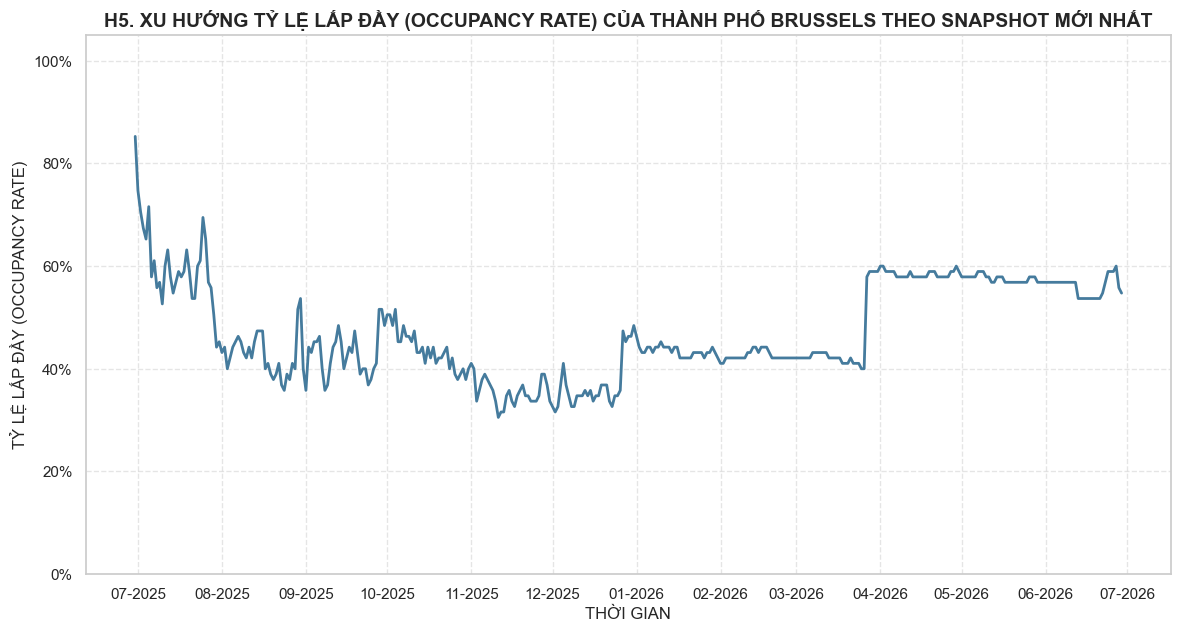

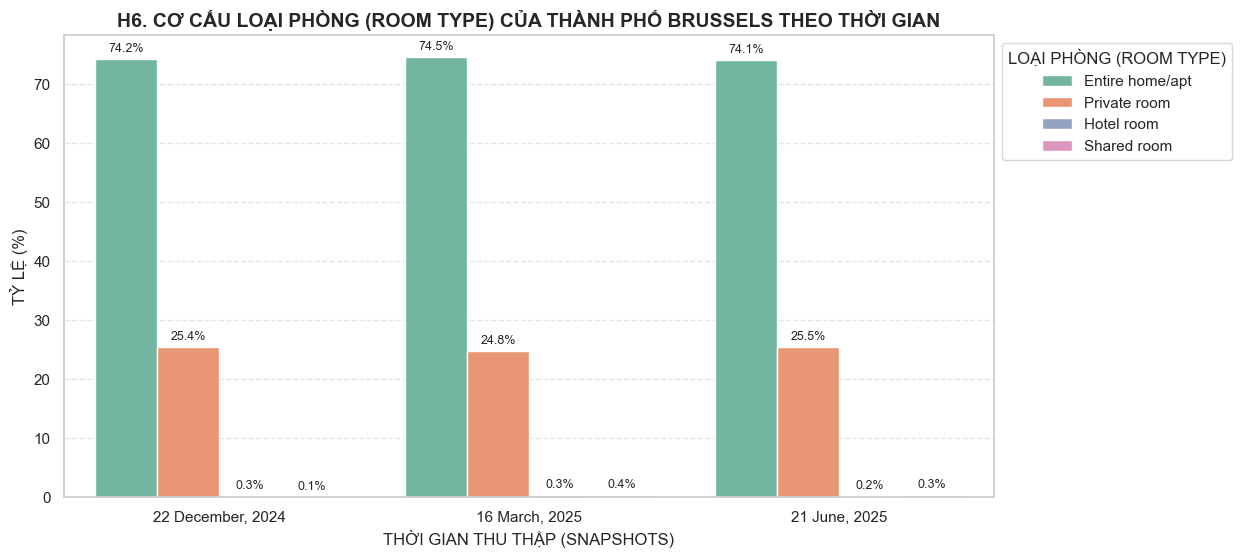

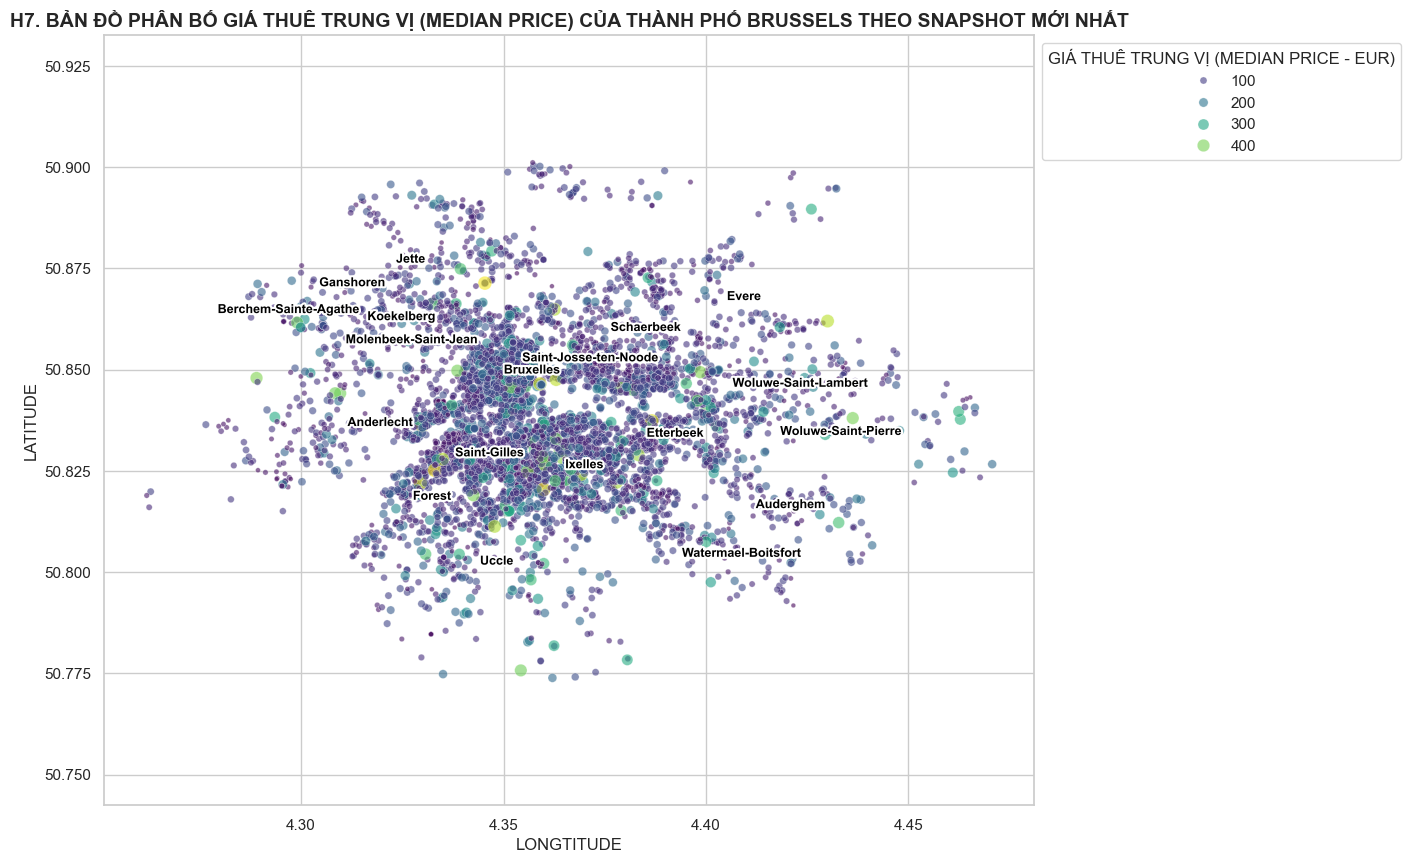

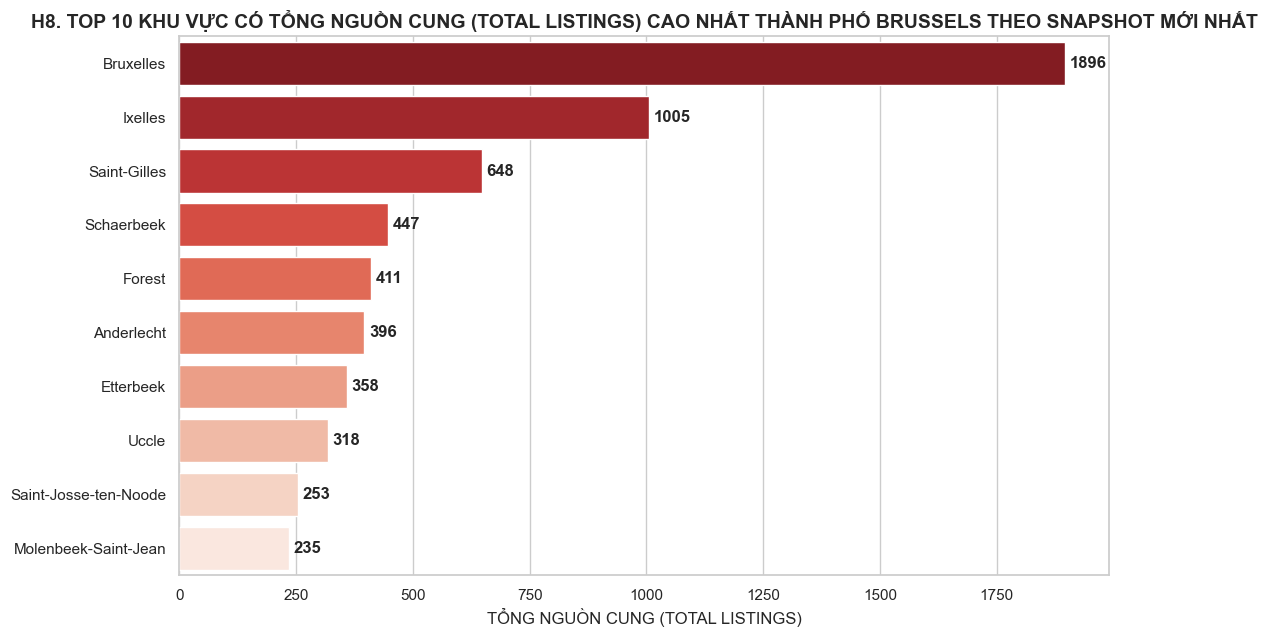

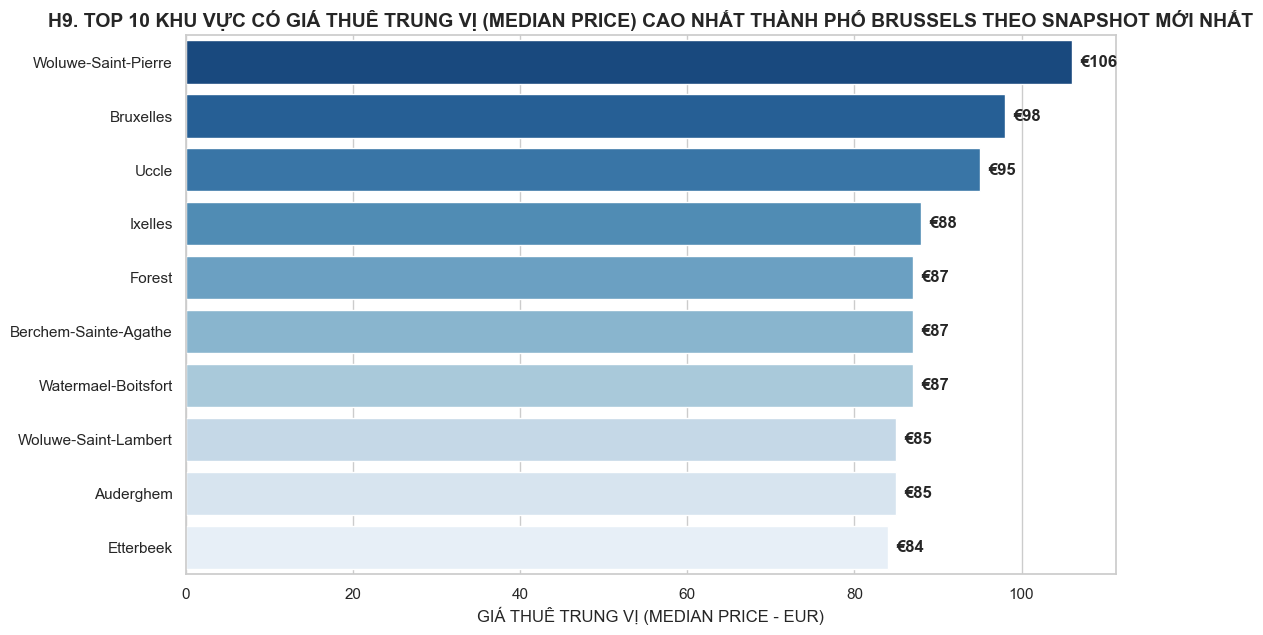

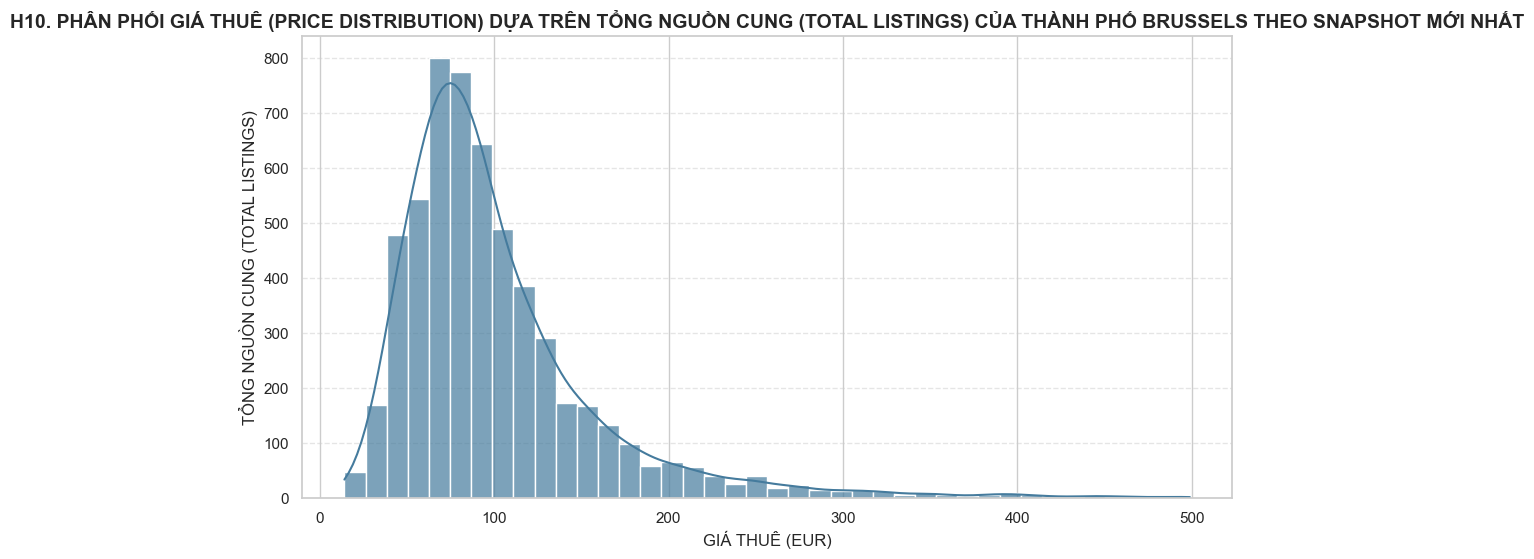

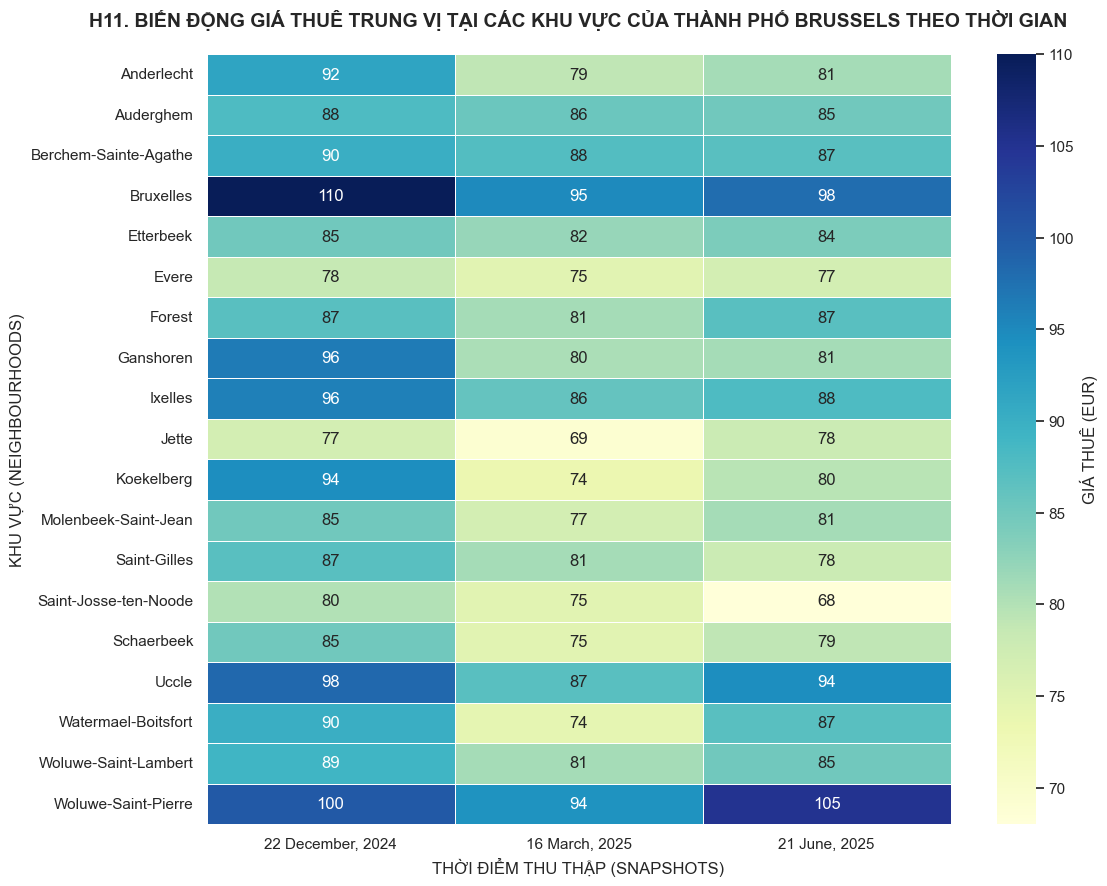

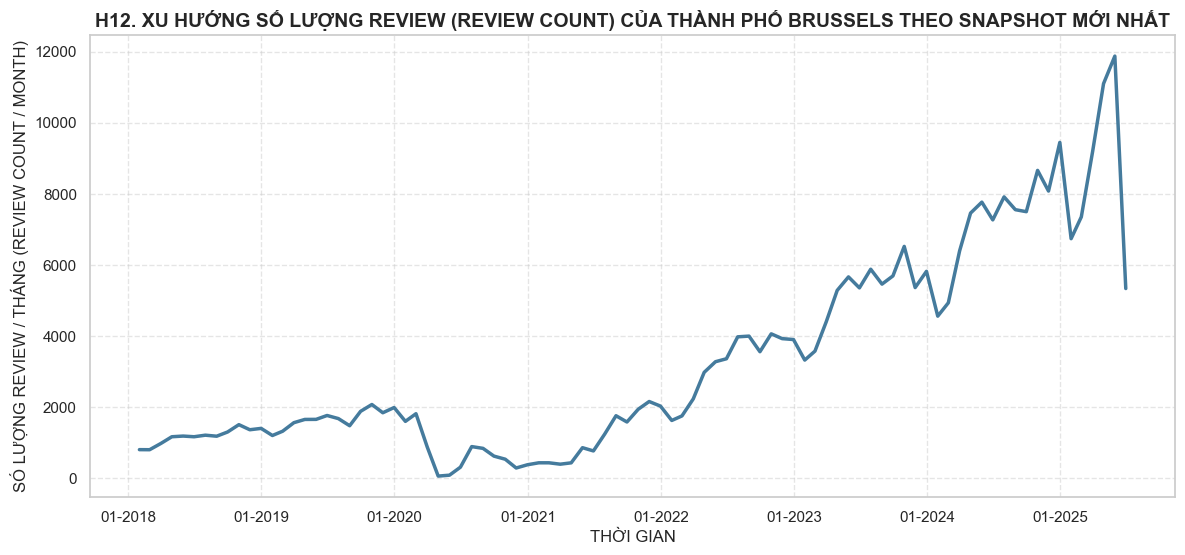

In [1]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
import matplotlib.dates as mdates
import matplotlib.ticker as mtick

# --- 1. THIẾT LẬP ---
sns.set_theme(style="whitegrid")
BASE_DIR = '..'
PROCESSED_DIR = os.path.join(BASE_DIR, 'processed', 'brussels')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
CITY_SUFFIX = 'brussels'

print("--- BẮT ĐẦU VẼ CHUYÊN SÂU CHO BRUSSELS ---")

# --- BỔ SUNG: NẠP FILE KPI MỚI ---
try:
    kpi_neigh = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_neighbourhood_{CITY_SUFFIX}.csv'))
    kpi_review = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_reviews_trend_{CITY_SUFFIX}.csv'))
except FileNotFoundError:
    kpi_neigh = pd.DataFrame()
    kpi_review = pd.DataFrame()


# --- 2. NẠP DỮ LIỆU KPI ---
try:
    # Load các file KPI đã tạo
    kpi_supply = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_summary_general_{CITY_SUFFIX}.csv'))
    kpi_room = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_room_type_{CITY_SUFFIX}.csv'))
    kpi_season = pd.read_csv(os.path.join(PROCESSED_DIR, f'kpi_seasonality_{CITY_SUFFIX}.csv'))

    # Hàm sắp xếp thời gian
    def sort_by_date(df, date_col='snapshot_date'):
        df['dt'] = pd.to_datetime(df[date_col], errors='coerce')
        return df.sort_values('dt')

    kpi_supply = sort_by_date(kpi_supply)
    # kpi_room và kpi_season sẽ xử lý riêng khi vẽ
    print("--- ĐANG NẠP DỮ LIỆU TỔNG HỢP ---")
except FileNotFoundError as e:
    print(f"❌ Lỗi: Không tìm thấy file KPI. Chi tiết: {e}")
    kpi_supply = pd.DataFrame() # Tạo dataframe rỗng để code không crash

# --- 3. NẠP DỮ LIỆU CHI TIẾT (LATEST SNAPSHOT) ---
from datetime import datetime

def parse_snapshot_name(name):
    """
    Parse tên thư mục snapshot dạng '21 June, 2025' thành datetime.
    Trả về None nếu parse thất bại.
    """
    try:
        return datetime.strptime(name.strip(), "%d %B, %Y")
    except:
        return None

df_detail = pd.DataFrame()
LATEST_SNAPSHOT = "Unknown"

if os.path.exists(PROCESSED_DIR):

    # Lấy danh sách thư mục + chỉ giữ thư mục có format date hợp lệ
    raw_snaps = [
        d for d in os.listdir(PROCESSED_DIR)
        if os.path.isdir(os.path.join(PROCESSED_DIR, d))
    ]

    # Parse + giữ lại snapshot hợp lệ
    snapshots = [s for s in raw_snaps if parse_snapshot_name(s) is not None]

    # Sort theo ngày (mới nhất trước)
    snapshots = sorted(
        snapshots,
        key=lambda x: parse_snapshot_name(x),
        reverse=True
    )

    # Lấy file mới nhất
    for snap in snapshots:
        file_path = os.path.join(PROCESSED_DIR, snap, 'listings_processed.csv')
        if os.path.exists(file_path):
            try:
                temp = pd.read_csv(file_path, low_memory=False)
                if not temp.empty and 'price_numeric' in temp.columns:
                    df_detail = temp
                    LATEST_SNAPSHOT = snap
                    break
            except:
                continue


# --- 4. VẼ BIỂU ĐỒ ---

# === H1: Xu hướng Nguồn Cung (Bar Chart) ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(data=kpi_supply, x='snapshot_date', y='total_listings', color='#457B9D', width=0.5)
    plt.title('H1. XU HƯỚNG TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BRUSSELS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax1.containers: ax1.bar_label(i, padding=3, fontsize=11, fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_01_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H2: Xu hướng Giá (Line/Area Chart) ===
if not kpi_supply.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['median_price'], marker='o', linewidth=3, color='#457B9D')
    plt.fill_between(kpi_supply['snapshot_date'], kpi_supply['median_price'], color='#457B9D', alpha=0.1)
    plt.title('H2. XU HƯỚNG GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BRUSSELS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['median_price']):
        plt.text(x, y + 2, f"€{y:.0f}", ha='center', va='bottom', fontsize=11, fontweight='bold')
    plt.ylim(bottom=0, top=kpi_supply['median_price'].max()*1.2)
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_02_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()

# === H3: XU HƯỚNG TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) ===
if not kpi_supply.empty and 'multi_host_rate' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    plt.plot(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate'], marker='s', linewidth=3, color='#457B9D')
    
    plt.title(f'H3. TỶ LỆ CHỦ NHÀ CHUYÊN NGHIỆP (MULTI-HOST RATE) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.ylim(0, 100) # Tỷ lệ luôn trong thang 0-100
    
    # Hiển thị số % trên điểm
    for x, y in zip(kpi_supply['snapshot_date'], kpi_supply['multi_host_rate']):
        plt.text(x, y + 2, f"{y:.1f}%", ha='center', va='bottom', fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_03_multi_host.pdf'), format='pdf', bbox_inches='tight')
    plt.show()



# === H4: XU HƯỚNG ĐỘ SẴN SÀNG (AVAILABILITY 90) ===
if not kpi_supply.empty and 'median_avail_90' in kpi_supply.columns:
    plt.figure(figsize=(10, 6))
    ax12 = sns.barplot(data=kpi_supply, x='snapshot_date', y='median_avail_90', color='#457B9D', width=0.5)
    
    plt.title(f'H4. XU HƯỚNG ĐỘ SẴN SÀNG TRUNG VỊ (MEDIAN AVAILABILITY 90) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ NGÀY TRỐNG (TRONG 90 NGÀY TỚI)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Label
    for i in ax12.containers: ax12.bar_label(i, padding=3, fontsize=11, fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_04_availability.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H5: Xu hướng Lấp đầy (Occupancy Rate - Line Chart) ===
if not kpi_season.empty:
    df_h5 = kpi_season.copy()
    # Chuyển đổi ngày tháng
    df_h5['date_dt'] = pd.to_datetime(df_h5['date'], errors='coerce')
    df_h5['snapshot_dt'] = pd.to_datetime(df_h5['snapshot_date'], errors='coerce')
    
    # Lấy dữ liệu từ snapshot MỚI NHẤT
    latest_snap_dt = df_h5['snapshot_dt'].max()
    df_final_h5 = df_h5[df_h5['snapshot_dt'] == latest_snap_dt].sort_values('date_dt')

    if not df_final_h5.empty:
        plt.figure(figsize=(14, 7))
        sns.lineplot(data=df_final_h5, x='date_dt', y='occupancy_rate', color='#457B9D', linewidth=2)
        
        # Format trục
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

        plt.title(f'H5. XU HƯỚNG TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE) CỦA THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', 
                  fontsize=14, fontweight='bold')
        plt.ylabel('TỶ LỆ LẤP ĐẦY (OCCUPANCY RATE)')
        plt.xlabel('THỜI GIAN')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.ylim(0, 1.05)
        
        
        plt.savefig(os.path.join(FIGURES_DIR, 'brussels_05_occupancy.pdf'), format='pdf', bbox_inches='tight')
        plt.show()
        
    else:
        print("   ! Không có dữ liệu occupancy cho snapshot mới nhất.")
else:
    print("   ! Không có dữ liệu seasonality.")


# === H6: Cơ cấu Loại phòng (Grouped Bar) ===
if not kpi_room.empty:
    plt.figure(figsize=(12, 6))
    kpi_room['dt'] = pd.to_datetime(kpi_room['snapshot_date'], errors='coerce')
    kpi_room = kpi_room.sort_values('dt')
    
    ax3 = sns.barplot(data=kpi_room, x='snapshot_date', y='percentage', hue='room_type', palette='Set2')
    plt.title('H6. CƠ CẤU LOẠI PHÒNG (ROOM TYPE) CỦA THÀNH PHỐ BRUSSELS THEO THỜI GIAN', fontsize=14, fontweight='bold')
    plt.ylabel('TỶ LỆ (%)')
    plt.xlabel('THỜI GIAN THU THẬP (SNAPSHOTS)')
    plt.legend(title='LOẠI PHÒNG (ROOM TYPE)', bbox_to_anchor=(1, 1))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i in ax3.containers: ax3.bar_label(i, fmt='%.1f%%', padding=3, fontsize=9)
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_06_room_type.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H7: Bản đồ Phân bố Listing (Scatter Map) ===
if not df_detail.empty and 'latitude' in df_detail.columns:
    plt.figure(figsize=(12, 10))
    
    # Vẽ điểm (lọc giá < 500)
    sns.scatterplot(
        data=df_detail[df_detail['price_numeric'] < 500], 
        x='longitude', y='latitude', 
        hue='price_numeric', palette='viridis', 
        size='price_numeric', sizes=(10, 100), alpha=0.6,
        legend='brief'
    )

    # Gắn nhãn tên khu vực
    if 'neighbourhood_cleansed' in df_detail.columns:
        neigh_centers = df_detail.groupby('neighbourhood_cleansed')[['latitude', 'longitude']].mean().reset_index()
        for i, row in neigh_centers.iterrows():
            txt = plt.text(
                row['longitude'], row['latitude'], 
                row['neighbourhood_cleansed'], 
                fontsize=9, fontweight='bold', color='black',
                ha='center', va='center'
            )
            txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

    plt.title(f'H7. BẢN ĐỒ PHÂN BỐ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CỦA THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('LONGTITUDE')
    plt.ylabel('LATITUDE')
    plt.legend(title='GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)', bbox_to_anchor=(1, 1), loc='upper left')
    plt.axis('equal') 
    
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_07_map_labeled.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    

# === H8: TOP 10 KHU VỰC CÓ NHIỀU LISTINGS NHẤT ===
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    top_supply_neigh = df_detail['neighbourhood_cleansed'].value_counts().head(10).reset_index()
    top_supply_neigh.columns = ['neighbourhood_cleansed', 'count']

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=top_supply_neigh,
        y='neighbourhood_cleansed',
        x='count',
        palette='Reds_r',
        hue='neighbourhood_cleansed',
        legend=False
    )
    plt.title(f'H8. TOP 10 KHU VỰC CÓ TỔNG NGUỒN CUNG (TOTAL LISTINGS) CAO NHẤT THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.ylabel('')
    for i, v in enumerate(top_supply_neigh['count']):
        plt.text(v + 10, i, f"{v}", va='center', fontweight='bold')
        
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_08_top10_supply.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H9: Top 10 Khu vực Đắt đỏ nhất (Bar Chart) ===
if not df_detail.empty and 'neighbourhood_cleansed' in df_detail.columns:
    neigh_price = df_detail.groupby('neighbourhood_cleansed')['price_numeric'].median().sort_values(ascending=False).head(10).reset_index()

    plt.figure(figsize=(12, 7))
    sns.barplot(
        data=neigh_price, 
        y='neighbourhood_cleansed', 
        x='price_numeric', 
        palette='Blues_r', 
        hue='neighbourhood_cleansed', 
        legend=False
    )
    plt.title(f'H9. TOP 10 KHU VỰC CÓ GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE) CAO NHẤT THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ TRUNG VỊ (MEDIAN PRICE - EUR)')
    plt.ylabel('')
    for i, v in enumerate(neigh_price['price_numeric']):
        plt.text(v + 1, i, f"€{v:.0f}", va='center', fontweight='bold')
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_09_top10_price.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
    


# === H10: PHÂN PHỐI GIÁ THUÊ (HISTOGRAM + KDE) ===
if not df_detail.empty and 'price_numeric' in df_detail.columns:
    plt.figure(figsize=(12, 6))
    
    sns.histplot(
        df_detail[df_detail['price_numeric'] < 500]['price_numeric'],
        kde=True,
        bins=40,
        color='#457B9D',
        alpha=0.7
    )
    
    plt.title(f'H10. PHÂN PHỐI GIÁ THUÊ (PRICE DISTRIBUTION) DỰA TRÊN TỔNG NGUỒN CUNG (TOTAL LISTINGS) CỦA THÀNH PHỐ BRUSSELS THEO SNAPSHOT MỚI NHẤT',
              fontsize=14, fontweight='bold')
    plt.xlabel('GIÁ THUÊ (EUR)')
    plt.ylabel('TỔNG NGUỒN CUNG (TOTAL LISTINGS)')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_10_price_distribution.pdf'), 
                format='pdf', bbox_inches='tight')
    plt.show()
    


# === H11: HEATMAP BIẾN ĐỘNG GIÁ THEO KHU VỰC (PHIÊN BẢN TỐI ƯU) ===
if not kpi_neigh.empty:
    # 1. Lọc lấy Top 20 khu vực có nhiều phòng nhất (để Heatmap đỡ rối)
    top_areas = kpi_neigh.groupby('neighbourhood')['listing_count'].sum().sort_values(ascending=False).head(20).index
    df_heat = kpi_neigh[kpi_neigh['neighbourhood'].isin(top_areas)].copy()
    
    # 2. Pivot bảng
    heatmap_data = df_heat.pivot_table(index='neighbourhood', columns='snapshot_date', values='median_price')
    
    # 3. Sắp xếp cột theo thời gian
    sorted_cols = sorted(heatmap_data.columns, key=parse_snapshot_name)
    heatmap_data = heatmap_data[sorted_cols]

    # 4. Vẽ Heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlGnBu', linewidths=.5, cbar_kws={'label': 'GIÁ THUÊ (EUR)'})
    
    plt.title(f'H11. BIẾN ĐỘNG GIÁ THUÊ TRUNG VỊ TẠI CÁC KHU VỰC CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO THỜI GIAN', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('THỜI ĐIỂM THU THẬP (SNAPSHOTS)')
    plt.ylabel('KHU VỰC (NEIGHBOURHOODS)')
    
    plt.savefig(os.path.join(FIGURES_DIR, f'{CITY_SUFFIX}_11_price_heatmap_optimized.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu KPI Neighbourhood để vẽ H11.")



# === H12: XU HƯỚNG LƯỢNG REVIEW (NHU CẦU DU LỊCH) ===
if not kpi_review.empty:
    plt.figure(figsize=(14, 6))
    
    # 1. Tìm snapshot mới nhất (Logic chuẩn xác nhất)
    kpi_review['snap_dt'] = pd.to_datetime(kpi_review['snapshot_date'], errors='coerce')
    latest_snap_date = kpi_review['snap_dt'].max()
    
    # 2. Chỉ lọc lấy dữ liệu review của snapshot đó
    df_rev_final = kpi_review[kpi_review['snap_dt'] == latest_snap_date].copy()
    
    # 3. Xử lý ngày tháng
    df_rev_final['date'] = pd.to_datetime(df_rev_final['date'])
    df_rev_final = df_rev_final.sort_values('date')
    
    # 4. Lọc năm (2018 trở lại)
    df_rev_final = df_rev_final[df_rev_final['date'].dt.year >= 2018]

    # 5. Vẽ
    sns.lineplot(data=df_rev_final, x='date', y='review_count', color='#457B9D', linewidth=2.5)
    
    plt.title(f'H12. XU HƯỚNG SỐ LƯỢNG REVIEW (REVIEW COUNT) CỦA THÀNH PHỐ {CITY_SUFFIX.upper()} THEO SNAPSHOT MỚI NHẤT', fontsize=14, fontweight='bold')
    plt.ylabel('SỐ LƯỢNG REVIEW / THÁNG (REVIEW COUNT / MONTH)')
    plt.xlabel('THỜI GIAN')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
    
    plt.savefig(os.path.join(FIGURES_DIR, 'brussels_12_reviews_trend.pdf'), format='pdf', bbox_inches='tight')
    plt.show()
else:
    print("⚠️ Không có dữ liệu Review Trend để vẽ H12.")




